<a href="https://colab.research.google.com/github/fnd-lip/NLW_rocketseat/blob/main/ATV4_Avanti_parte_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ATIV04 ET01 - Análise do Dataset de Imagens

# 📦 Instalação de bibliotecas necessárias

___

In [ ]:
!pip install opendatasets pandas imagehash scikit-image seaborn

# 📚 Importação de bibliotecas
___

In [17]:
import opendatasets as od
import os, cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, UnidentifiedImageError
import imagehash
from collections import Counter
import seaborn as sns
from IPython.display import display, Markdown

## 📂 Download e preparação do dataset


---



In [ ]:
od.download("https://www.kaggle.com/datasets/trolukovich/food5k-image-dataset")

Skipping, found downloaded files in "./food5k-image-dataset" (use force=True to force download)


In [18]:
base_dir = "./food5k-image-dataset"
subdirs = ["training", "validation", "evaluation"]

## 🔍 1. Verificação de Integridade dos Arquivos

***Objetivo:***
* Verifique se todas as imagens listadas no arquivo de informações realmente existem no diretório de imagens e vice-versa.
* Verifique se todas as imagens estão no mesmo formato, ex: JPEG, PNG, etc.


____

In [71]:
def verificar_integridade(image_paths, info_file=None):
  registros = []
  for path in image_paths:
      try:
          with Image.open(path) as img:
              registros.append({
                  "arquivo": os.path.basename(path),
                  "largura": img.size[0],
                  "altura": img.size[1],
                  "canais": len(img.getbands()),
                  "image_format": img.format
              })
      except Exception as e:
          registros.append({
              "arquivo": os.path.basename(path),
              "largura": None,
              "altura": None,
              "canais": None,
              "image_format": None
          })

  df = pd.DataFrame(registros)


  # Estatísticas descritivas
  display(Markdown("### 📊 Estatísticas das imagens (altura, largura e canais)"))
  display(df[["largura", "altura", "canais"]].describe().loc[["mean", "std", "min", "max"]])

  # Quantidade de imagens por formato
  display(Markdown("### 🖼️ Quantidade de Imagens por Formato"))
  ax = df["image_format"].value_counts().plot(
      kind="bar", title="Número de imagens por formato", figsize=(8,6)
  )
  plt.xticks(rotation=40)

  # Adiciona os valores acima das barras
  for p in ax.patches:
      ax.annotate(str(int(p.get_height())),
                  (p.get_x() + p.get_width() / 2, p.get_height()),
                  ha='center', va='bottom', fontsize=10)

  plt.show()

  return df


### 📊 Estatísticas das imagens (altura, largura e canais)

,largura,altura,canais
mean,599.79680,529.970600,2.995600
std,313.97287,247.203085,0.093714
min,160.00000,120.000000,1.000000
max,4992.00000,3328.000000,3.000000


### 🖼️ Quantidade de Imagens por Formato

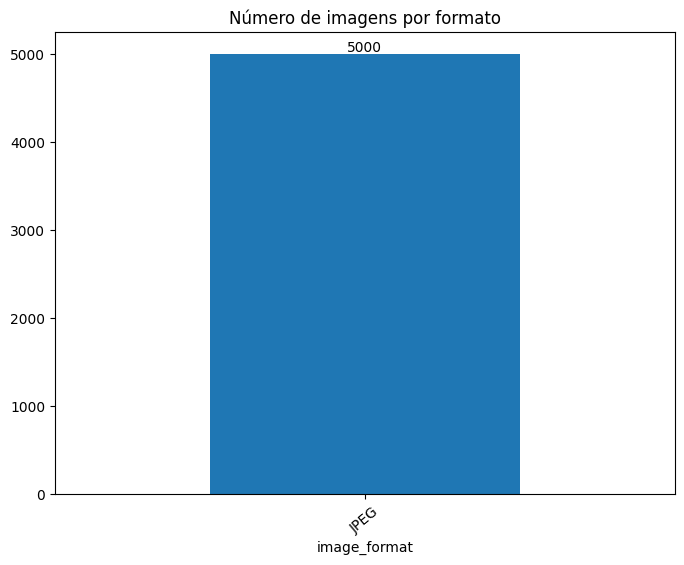

In [78]:
df_integridade = verificar_integridade(all_images)


## 🧾 2. Consistência dos Metadados

**objetivo:**

*  Verificar valores ausentes
* Verificar dimenssões ou formatos incosistentes
  



___


In [57]:
def verificar_consistencia_metadados(image_paths, min_dim=(50,50), max_dim=(5000,5000)):
  metadata = []
  for path in image_paths:
      try:
          with Image.open(path) as img:
              metadata.append({
                  "arquivo": os.path.basename(path),
                  "formato": img.format,
                  "largura": img.size[0],
                  "altura": img.size[1],
                  "modo": img.mode
              })
      except:
          metadata.append({
              "arquivo": os.path.basename(path),
              "formato": None,
              "largura": None,
              "altura": None,
              "modo": None
          })

  df_meta = pd.DataFrame(metadata)

  # Distribuição das dimensões
  display(Markdown("### 📏 Distribuição das Dimensões de Altura e Largura das Imagens"))
  plt.figure(figsize=(6,4))
  plt.scatter(df_meta["largura"], df_meta["altura"], alpha=0.5)
  plt.xlabel("Width")
  plt.ylabel("Height")
  plt.title("Distribution of Image Dimensions")
  plt.show()

  # Quantidade de informações nulas
  display(Markdown("### ⚠️ Quantidade de informações nulas nos metadados"))
  display(df_meta.isnull().sum())

  # Verificar inconsistentes (fora dos limites definidos)
  inconsistentes = df_meta[
      (df_meta["largura"].notnull()) &
      ((df_meta["largura"] < min_dim[0]) | (df_meta["altura"] < min_dim[1]) |
        (df_meta["largura"] > max_dim[0]) | (df_meta["altura"] > max_dim[1]))
  ]

  display(Markdown("### ⚠️ Metadados Inconsistentes (dimensões fora do esperado)"))
  if inconsistentes.empty:
      display(Markdown("✅ Nenhuma inconsistência encontrada"))
  else:
      display(inconsistentes)

  return df_meta, inconsistentes


### 📏 Distribuição das Dimensões de Altura e Largura das Imagens

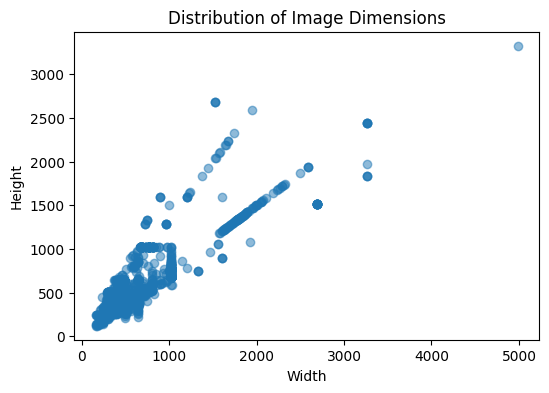

### ⚠️ Quantidade de informações nulas nos metadados

,0
arquivo,0
formato,0
largura,0
altura,0
modo,0


### ⚠️ Metadados Inconsistentes (dimensões fora do esperado)

✅ Nenhuma inconsistência encontrada

In [58]:
df_meta, inconsistentes = verificar_consistencia_metadados(all_images)

## 📉 3. Qualidade das Imagens

**Objetivo**

* Identifique imagens corrompidas que não podem ser abertas ou processadas
---



In [50]:
def verificar_qualidade(all_images, corrompidas):
  # Cria dataframe com flag de corrompida 1 ou não 0
  df_quality = pd.DataFrame({
      "Arquivo": all_images,
      "corrupted": [1 if path in [c[0] for c in corrompidas] else 0 for path in all_images]
  })

  # Total de imagens corrompidas
  print("\n### ⚡ Total de imagens corrompidas")
  print(df_quality["corrupted"].sum())

  return df_quality


In [51]:
df_corrompidas = verificar_qualidade(all_images,corrompidas)


### ⚡ Total de imagens corrompidas
0


## 📊 4. Distribuição das Classes

***Objetivo:***
* Verifique a distribuição das classes para identificar possíveis desequilíbrios que possam afetar a modelagem

___

In [59]:
def verificar_distribuicao_classes(base_dir, subdirs):
  classes = []
  for subdir in subdirs:
      for root, _, files in os.walk(os.path.join(base_dir, subdir)):
          for file in files:
              if file.lower().endswith(('.png','.jpg','.jpeg')):
                  label = os.path.basename(root)
                  classes.append(label)

  df_classes = pd.DataFrame(classes, columns=["Classe"])
  display(Markdown("### 📊 Distribuição das Classes"))
  sns.countplot(x="Classe", data=df_classes)
  plt.title("Distribuição das Classes no Dataset")
  plt.show()

  return df_classes.value_counts()




### 📊 Distribuição das Classes

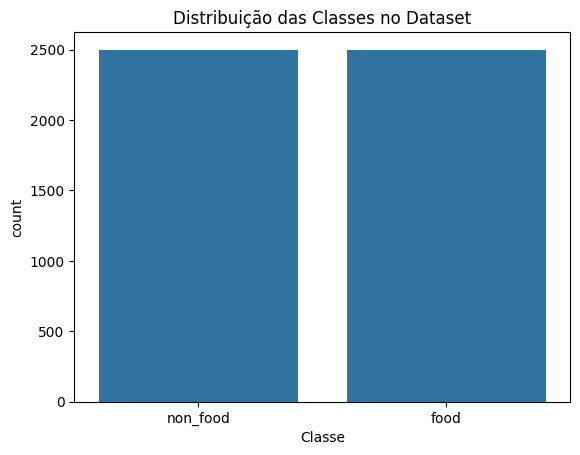

In [60]:
dist_classes = verificar_distribuicao_classes(base_dir, subdirs)

## 🔁 5. Detecção de Duplicatas

Objetivo:
* Identifique imagens duplicadas que possam enviesar os resultados.
* Verifique duplicatas no arquivo de informações
___


In [81]:
def verificar_duplicatas(image_paths, info_file=None, max_plot=None, hash_size=8, threshold=5):
  hashes, duplicatas = {}, []

  # Verificação de duplicatas no diretório
  for path in image_paths:
      try:
          with Image.open(path) as img:
              h = imagehash.phash(img, hash_size=hash_size)
              duplicado = False
              for h_existente, p_existente in hashes.items():
                  if h - h_existente <= threshold:  # tolerância
                      duplicatas.append((path, p_existente, h - h_existente))
                      duplicado = True
                      break
              if not duplicado:
                  hashes[h] = path
      except Exception as e:
          print(f"⚠️ Erro ao processar {path}: {e}")
          continue

  df_dup = pd.DataFrame(duplicatas, columns=["Imagem", "Duplicata de", "Diferença Hash"])
  display(Markdown("### 🔁 Imagens Duplicadas no Diretório"))
  display(df_dup if not df_dup.empty else Markdown("✅ Nenhuma duplicata encontrada no diretório"))

  # Plotar algumas duplicatas
  if not df_dup.empty:
      total_plot = len(df_dup) if max_plot is None else min(len(df_dup), max_plot)
      display(Markdown(f"### 👀 Visualização de {total_plot} pares de duplicatas"))
      for i, row in df_dup.head(total_plot).iterrows():
          fig, axes = plt.subplots(1, 2, figsize=(6, 3))
          try:
              img1 = Image.open(row["Imagem"]).convert("RGB")
              img2 = Image.open(row["Duplicata de"]).convert("RGB")
              axes[0].imshow(img1)
              axes[0].set_title("Imagem")
              axes[0].axis("off")
              axes[1].imshow(img2)
              axes[1].set_title(f"Duplicata (Δ={row['Diferença Hash']})")
              axes[1].axis("off")
              plt.show()
          except Exception as e:
              print(f"⚠️ Erro ao exibir {row['Imagem']} e {row['Duplicata de']}: {e}")
              continue

  # Verificação de duplicatas no arquivo de informações (se existir)
  if info_file and os.path.exists(info_file):
      df_info = pd.read_csv(info_file)
      df_dup_info = df_info[df_info.duplicated()]
      display(Markdown("### 🔁 Duplicatas no Arquivo de Informações"))
      display(df_dup_info if not df_dup_info.empty else Markdown("✅ Nenhuma duplicata no arquivo"))

  return df_dup


### 🔁 Imagens Duplicadas no Diretório

,Imagem,Duplicata de,Diferença Hash
0,./food5k-image-dataset/training/non_food/1296.jpg,./food5k-image-dataset/training/non_food/1487.jpg,0
1,./food5k-image-dataset/training/non_food/1442.jpg,./food5k-image-dataset/training/non_food/1409.jpg,0
2,./food5k-image-dataset/training/non_food/1200.jpg,./food5k-image-dataset/training/non_food/1444.jpg,0
3,./food5k-image-dataset/training/non_food/1451.jpg,./food5k-image-dataset/training/non_food/1345.jpg,0
4,./food5k-image-dataset/training/non_food/1471.jpg,./food5k-image-dataset/training/non_food/1426.jpg,0
5,./food5k-image-dataset/training/non_food/358.jpg,./food5k-image-dataset/training/non_food/783.jpg,2
6,./food5k-image-dataset/training/non_food/669.jpg,./food5k-image-dataset/training/non_food/886.jpg,0
7,./food5k-image-dataset/training/non_food/53.jpg,./food5k-image-dataset/training/non_food/17.jpg,4
8,./food5k-image-dataset/training/non_food/549.jpg,./food5k-image-dataset/training/non_food/244.jpg,2
9,./food5k-image-dataset/training/food/1267.jpg,./food5k-image-dataset/training/food/550.jpg,0


### 👀 Visualização de 31 pares de duplicatas

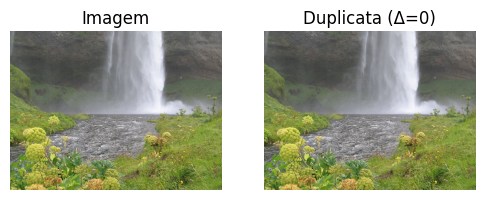

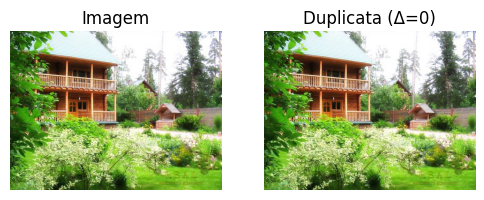

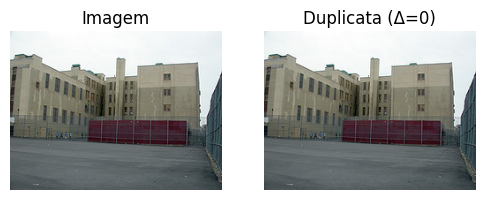

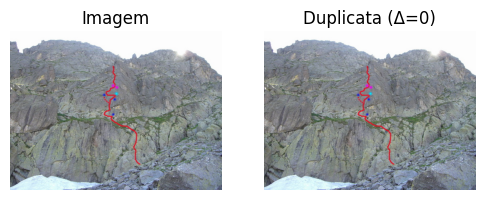

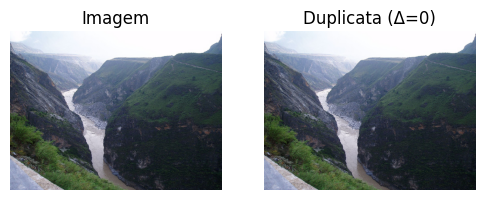

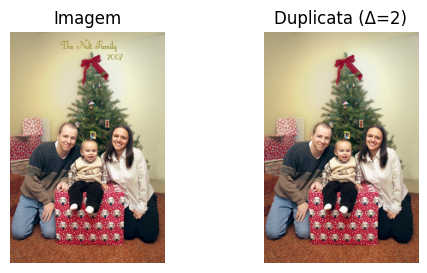

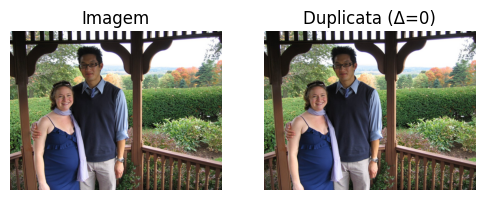

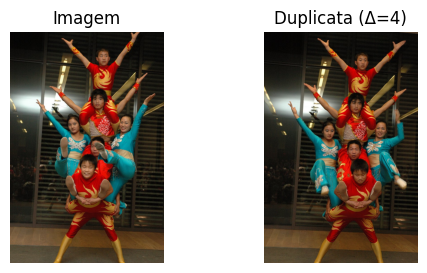

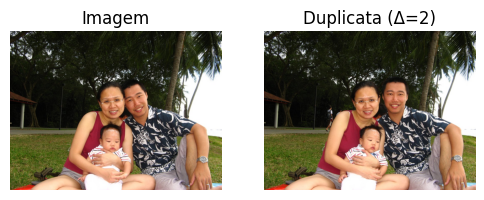

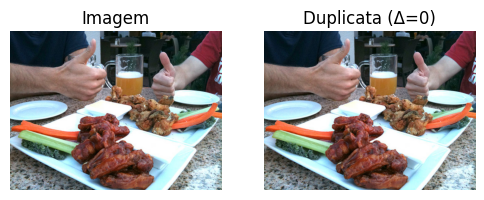

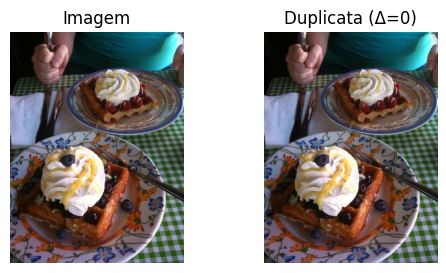

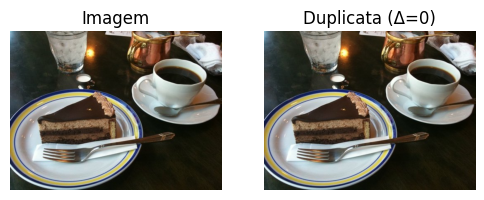

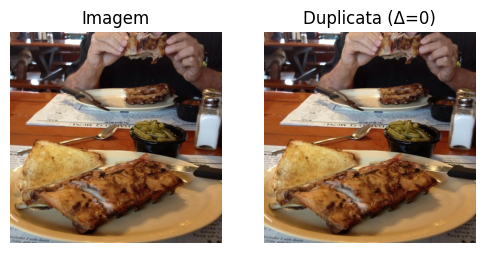

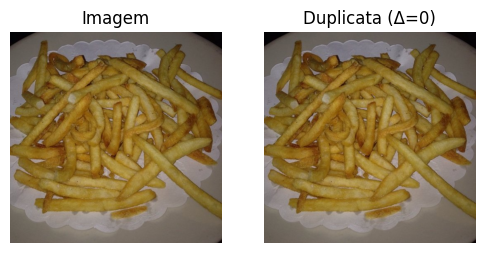

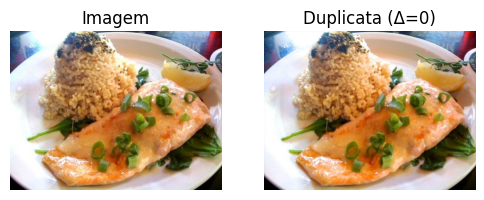

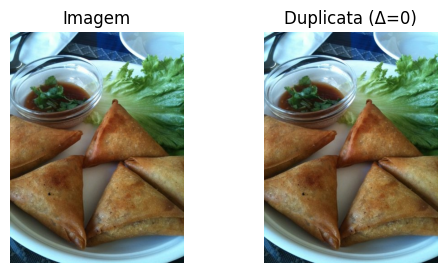

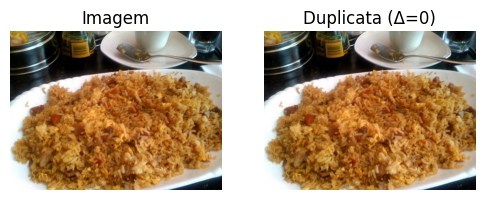

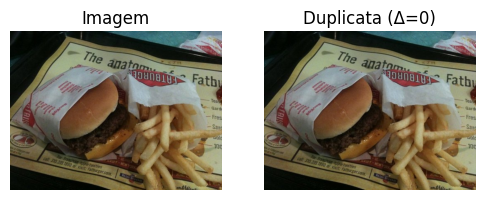

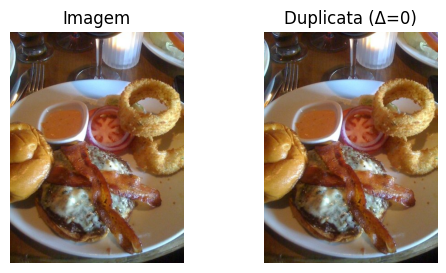

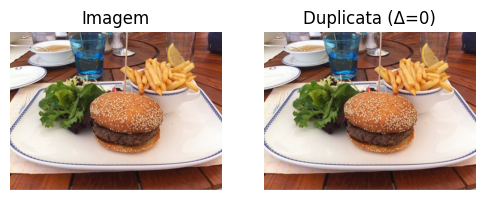

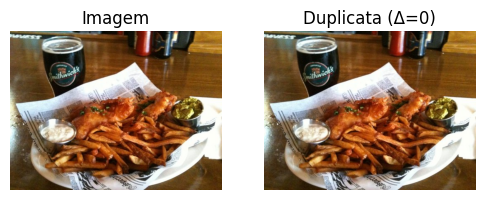

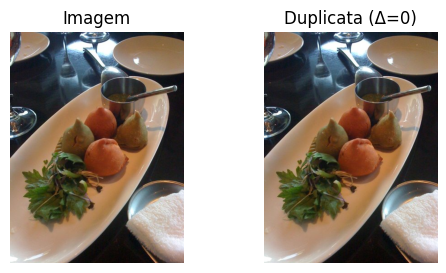

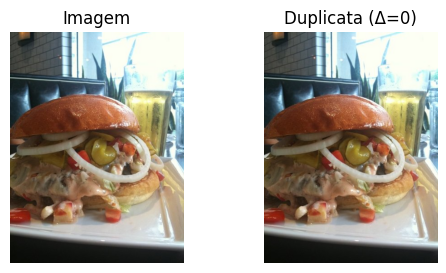

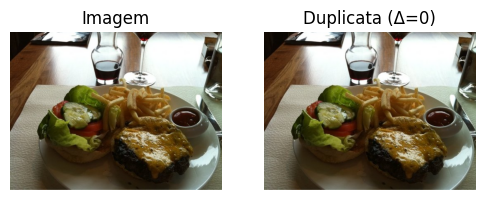

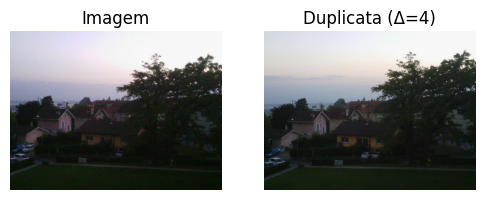

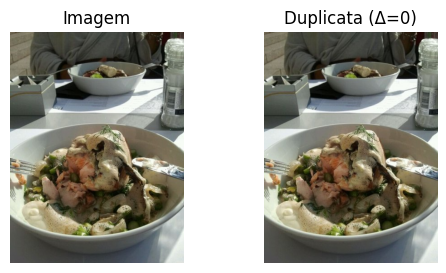

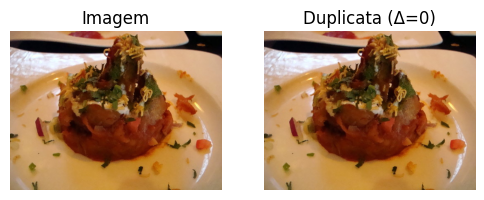

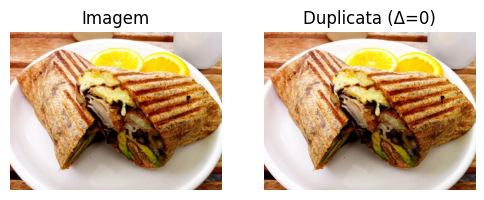

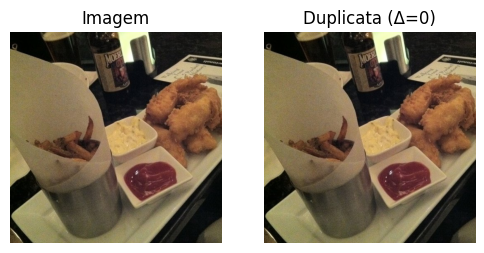

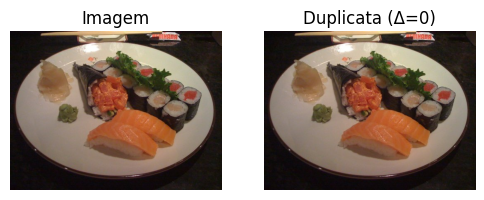

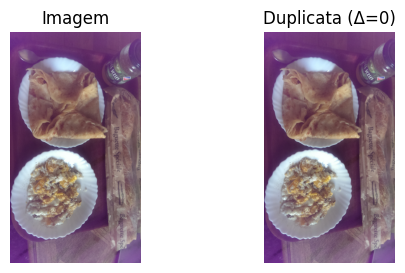

In [82]:
df_duplicatas = verificar_duplicatas(all_images)